First We Import the necessary packages and set global variables

In [1]:
# importing packages
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller


from math import pi
import numpy as np

from qiskit.tools.visualization import plot_histogram

# setting global varibles
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)

n_shots = 2**13
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')


# Defining the functions that we will be using
First we define a custom nand gate since we will be using it a lot, so I decomposed the Toffoli gate to see where I can cut corners

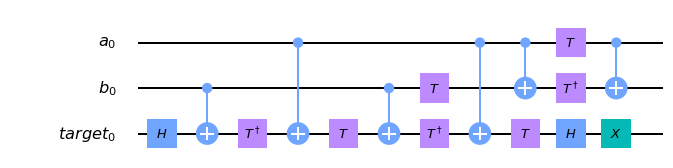

In [2]:
a = QuantumRegister(1,'a')
b = QuantumRegister(1,'b')
target = QuantumRegister(1,'target')

circuit = QuantumCircuit(a,b,target)

circuit.ccx(a,b,target)
circuit = circuit.decompose()
circuit.x(target)

circuit.draw(output='mpl')

I combned the last three consecutive gates into one u3 gate by noting that $XHT=u3(\frac{\pi}{2},0,\frac{\pi}{4})$ and I removed the gates that recovers the states a and b since they will be reversed in the oracle. I called it 'noisy_nand'

In [3]:
# custom nand gate
def noisy_nand():
    a = QuantumRegister(1,'a')
    b = QuantumRegister(1,'b')
    target = QuantumRegister(1,'target')

    circuit = QuantumCircuit(a,b,target)

    circuit.h(target)

    circuit.cx(b,target)
    circuit.tdg(target)
    circuit.cx(a,target)
    circuit.t(target)

    circuit.cx(b,target)
    circuit.tdg(target)
    circuit.cx(a,target)
    
    circuit.u3(pi/2,0,pi/4,target)
    
    return circuit.to_instruction()



I defined a function to check for the color exceptions (e.g neither 1 nor 4 are blue)

In [4]:
# takes two pairs of nodes and returns 1 if neither are 11
def neither(restore):
    
    a = QuantumRegister(2,'a')
    b = QuantumRegister(2,'b')
    ancilla = QuantumRegister(2,'anc')
    target = QuantumRegister(1,'target')

    circuit = QuantumCircuit(a,b,ancilla,target)

    # ancilla[0] = a is not 11
    circuit.append(noisy_nand(),[a[0],a[1],ancilla[0]])
    # ancilla[1] = b is not 11
    circuit.append(noisy_nand(),[b[0],b[1],ancilla[1]])
    
    # target = a and b are not 11
    circuit.ccx(ancilla[0],ancilla[1],target)

    # whether we want to restore the ancilla qubits to save some operations
    if(restore):
        circuit.append(noisy_nand().inverse(),[b[0],b[1],ancilla[1]])
        circuit.append(noisy_nand().inverse(),[a[0],a[1],ancilla[0]])
    

    return circuit.to_instruction()

I defined a function to check if two nodes are of the same color

In [5]:
# compares two pairs of qubuits if the are equal or not
def compare(i):

    a = QuantumRegister(2,'a')
    b = QuantumRegister(2,'b')
    t = QuantumRegister(1,'target')

    circuit = QuantumCircuit(a,b,t)


    # are the first significant bits different? put the result in b[0]
    if(i!=0):# a special case for qubit 0 since we have fixed the first bit to 0
        circuit.cx(a[0],b[0])
        
    # are the second significant bits different? put the result in b[1]
    circuit.cx(a[1],b[1])

    # are the first bits or the second bits different? (b[0] or b[1] = not ((not b[0]) and (not b[1])))
    
    circuit.x(b)
    
    #### this is a decomposed Toffoli similar to what I did with the noisy nand above
    circuit.h(t)

    circuit.cx(b[1],t)
    circuit.tdg(t)
    circuit.cx(b[0],t)
    circuit.t(t)

    circuit.cx(b[1],t)
    circuit.tdg(t)
    circuit.cx(b[0],t)
    circuit.u3(pi/2,0,pi/4,t)
    
    ####### restoring the states of b[0] and b[1] #########

    circuit.x(b)

    circuit.cx(a[1],b[1])
    
    if(i!=0):
        circuit.cx(a[0],b[0])
        
    return circuit.to_instruction()

I defined a function that takes the description of a graph and encodes it as a quantum circuit

In [6]:
# this will encode the graph into a subcircuit
def encode_graph(graph):

    # extract the number of nodes and edges
    n_nodes = max(map(max,graph))+1
    n_edges = len(graph)
    
    
    # Allocate quantum registers
    
    # we fix the first bit of the first qubit to 0 and do not allocate a qubit for it 
    nodes = QuantumRegister(2*n_nodes-1,'nodes') 
    ancilla = QuantumRegister(2,name='ancilla')
    edges = QuantumRegister(n_edges+4,'edges')

    # create the circuit
    circuit = QuantumCircuit(nodes,ancilla,edges,name='Graph')

    # encode each edge
    for k in range(n_edges):
        
        # extract the nodes' indecies, we assume that i<j
        i = graph[k][0]
        j = graph[k][1]
        
        # edges[k] = condition number k is satisfied
        if(i!=0):
            circuit.append(compare(i),[nodes[2*i-1],nodes[2*i],nodes[2*j-1],nodes[2*j],edges[k]])
        else:# if the first node use ancilla[0] as a placeholder
            circuit.append(compare(i),[ancilla[0],nodes[2*i],nodes[2*j-1],nodes[2*j],edges[k]])
        
 
    # make sure nodes 2 and 3 are not red
    
    circuit.x(nodes[2*2])# flip the second bit so that if it is red it will be 11
    circuit.x(nodes[2*3])# flip the second bit so that if it is red it will be 11
    
    # edges[n_edges] = neither 2 nor 3 are red
    circuit.append(neither(True),[nodes[2*2-1],nodes[2*2],nodes[2*3-1],nodes[2*3],ancilla[0],ancilla[1],edges[n_edges]])

    # make sure nodes 1 and 4 are not blue
    
    # flip both of their bits so that if the were blue they will be 11
    circuit.x(nodes[2*1-1])
    circuit.x(nodes[2*1])
    circuit.x(nodes[2*4-1])
    circuit.x(nodes[2*4])

    # edges[n_edges+1] = neither 1 nor 4 are blue
    circuit.append(neither(False),[nodes[2*1-1],nodes[2*1],nodes[2*4-1],nodes[2*4],ancilla[0],ancilla[1],edges[n_edges+1]])
    

    # edges[n_edges+2] = check if node 5 is green
    circuit.x(nodes[2*5-1])
    circuit.append(noisy_nand(),[nodes[2*5-1],nodes[2*5],edges[n_edges+2]])

    # edges[n_edges+3] = check if node 6 is green
    circuit.x(nodes[2*6-1])
    circuit.append(noisy_nand(),[nodes[2*6-1],nodes[2*6],edges[n_edges+3]])

    
    # return the graph subcircuit
    return circuit.to_instruction()

Now we have all the neccessary pieces for the oracle

In [7]:
# this will encode phase oracle into a subcircuit which does a phase flip if all the conditions are met
def oracle(graph):

    # extract the number of nodes and edges
    n_nodes = max(map(max,graph))+1
    n_edges = len(graph)

    # Allocate quantum registers
    
    # we fix the first bit of the first qubit to 0 and do not allocate a qubit for it 
    nodes = QuantumRegister(2*n_nodes-1,'nodes')
    ancilla = QuantumRegister(2,name='ancilla')
    edges = QuantumRegister(n_edges+4,'edges')

    # create the circuit
    circuit = QuantumCircuit(nodes,ancilla,edges,name='Oracle')

    # create the graph subcircuit
    graph_subcircuit = encode_graph(graph)
    # group the qubits into a set
    graph_qubits = [*nodes,*ancilla,*edges]

    # add the graph subcircuit
    circuit.append(graph_subcircuit,graph_qubits)
    
    # do a phase flip to the last qubit if all edges are 1s
    circuit.h(edges[len(edges)-1])
    
    # we reuse the nodes qubits as dirty ancillas
    circuit.mct(edges[0:len(edges)-1],edges[len(edges)-1],[*ancilla,*nodes],mode='basic-dirty-ancilla')
    
    circuit.h(edges[len(edges)-1])
    
    # reverse the operation
    circuit.append(graph_subcircuit.inverse(),graph_qubits)
    
    # return the oracle subcircuit
    return circuit.to_instruction()

In [8]:
# an n-qubit Grover inversion circuit
def inversion(n):

    # reverse the order of the bits
    register = QuantumRegister(n,'register')
    
    # create a circuit called 'Inversion' and add the registers
    circuit = QuantumCircuit(register,name='Inversion')
    
    # if the number of qubits is greater than 3, then add extra n-3 qubits to act
    # as ancillas for the multi control Toffoli gate
    if(n>3):
        # allocate quantum registers
        ancilla = QuantumRegister(n-3,'ancilla')
        # add the ancilla qubits to the circuit
        circuit.add_register(ancilla)
    else:
        ancilla = None
    
    # apply a Ry(pi/2) gate on the first n-1 qubits
    circuit.ry(pi/2,register[0:n-1])
    # apply a Z gate on the nth qubit
    circuit.z(register[-1])
    
    # apply multi control toffoli using the first n-1 qubits as control and the nth qubit as target
    circuit.mct(register[0:n-1], register[n-1], ancilla, mode='basic')
        
    # apply a Ry(pi/2) gate on the first n-1 qubits
    circuit.ry(-pi/2,register[0:n-1])
    # apply a Z gate on the nth qubit
    circuit.z(register[-1])
    
    # return the circuit instruction
    return circuit.to_instruction()

# IMPORTANT
Since node 2 in the graph is either green 11 or blue 01, we know for sure that the last bit is 1 so we do not need to encode it. However, we change the color-coding to A:01, B:00, C:11, D:10 during optimization so that the last bit is 0 instead of 1. This will save us a lot of cx operations since we do not need to run the gate if we know the control qubit is 0. For that, we also swap the labeling of two nodes (2 and 0) so that node 2 becomes node 0 for practical reasons.

# Getting the number of solutions
We can extract the number of possible solutions by running the circuit on all possible combinations by putting all nodes in a uniform superposition and checking the percentage of times we get all 1s on the edges' qubits

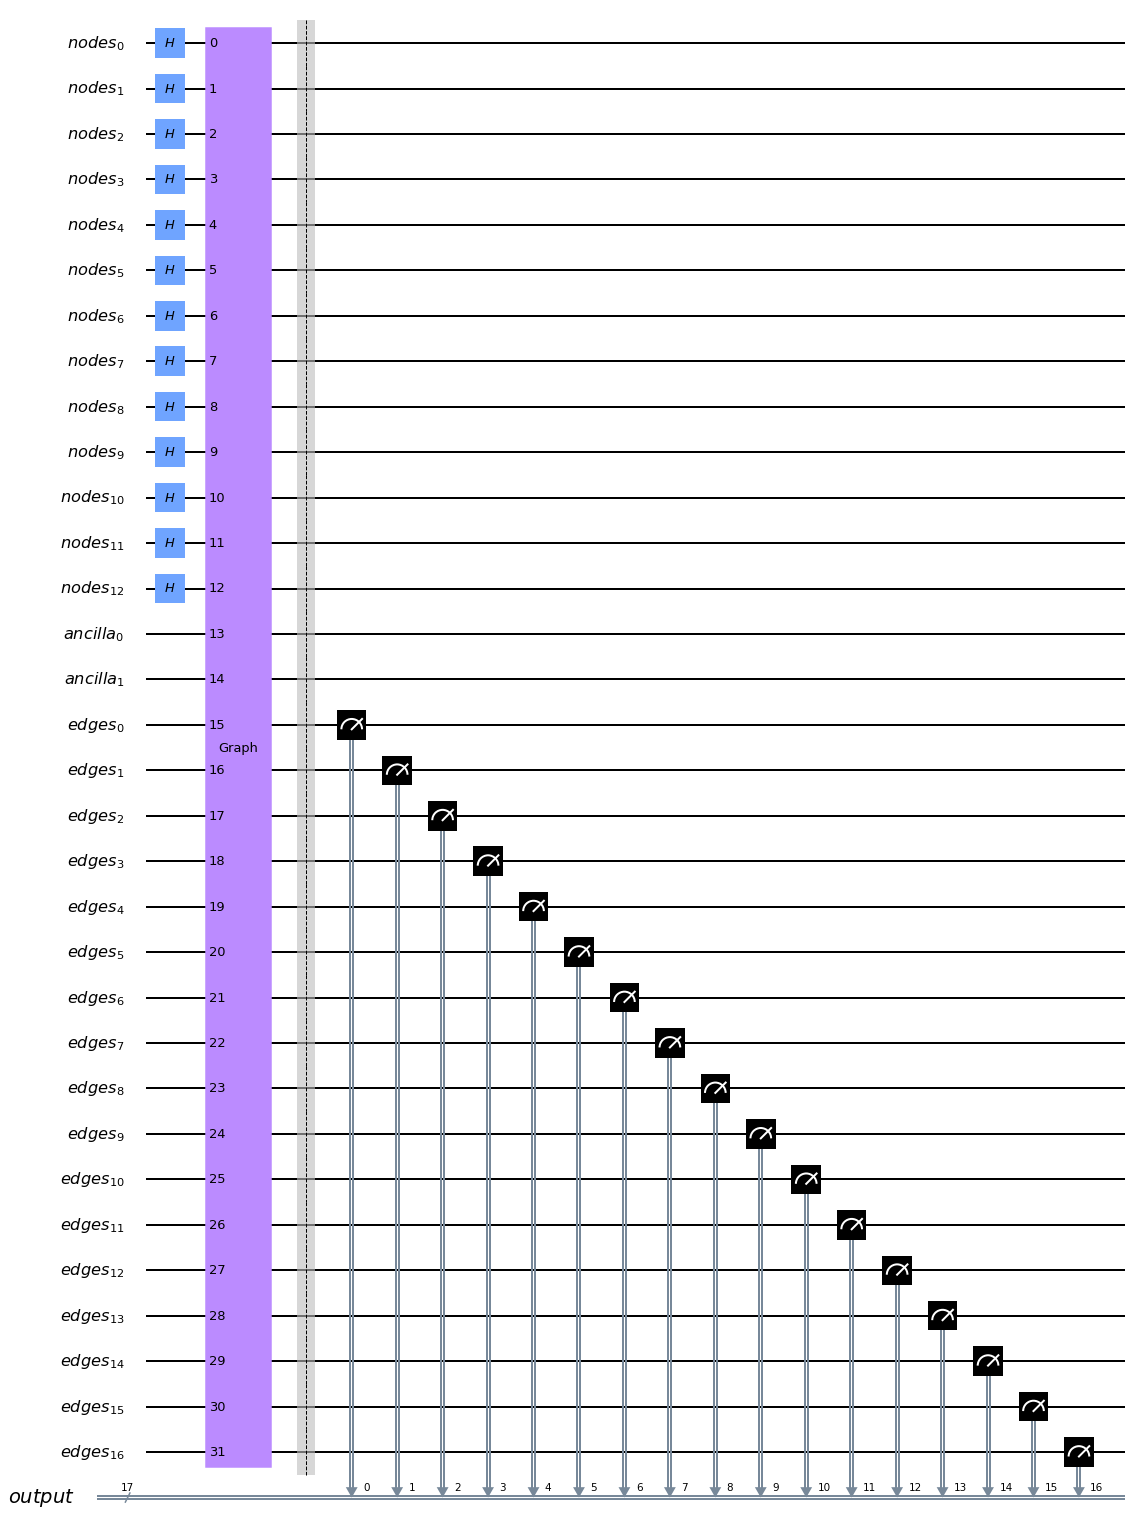

In [9]:
# encoding the graph (note that 2 is swapped with 0 for the reasons stated above)
graph = [[1,2],[0,2],[2,3],[1,3],[1,4],[0,3],[3,4],[0,5],[3,5],[0,6],[3,6],[4,6],[5,6]]

# extract the number of nodes and edges
n_nodes = max(map(max,graph))+1
n_edges = len(graph)

# we fix the first bit of the first qubit to 0 and do not allocate a qubit for it 
nodes = QuantumRegister(2*n_nodes-1,'nodes')
ancilla = QuantumRegister(2,name='ancilla')
edges = QuantumRegister(n_edges+4,'edges') # the number of edges + the 3-color exceptions

# allocating the classical registers to store the results
output = ClassicalRegister(len(edges),name='output')

# create the circuit
counting_circuit = QuantumCircuit(nodes,ancilla,edges,output)

# put all nodes in a uniform superposition
counting_circuit.h(nodes)

# create the grahp subcircuit
graph_subcircuit = encode_graph(graph)
# group qubits
graph_qubits = [*nodes,*ancilla,*edges]

# add the graph subcircuit
counting_circuit.append(graph_subcircuit,graph_qubits)
counting_circuit.barrier([*nodes,*ancilla,*edges])

# measure the results
counting_circuit.measure(edges,output)

counting_circuit.draw(output='mpl')

In [10]:
# executing the circuit and getting the results

counting_job = execute(counting_circuit, backend=backend, shots=n_shots, seed_simulator=12345, backend_options={"fusion_enable":True})
counting_results = counting_job.result()
counting_counts  = counting_results.get_counts()

In [11]:
# the percentage of all 1s 
percentage = counting_counts[''.join(['1']*len(output))]/n_shots

# the number of possible solutions is the percentage of times the number of a/ll possible combinations
num_solutions = int(np.floor(percentage*(2**(2*n_nodes-1))))
print('There are approximately', num_solutions,'possible solutions')

# the number of iterations needed to be as close as possible to certainty
k = int(np.round((pi/(4*np.arcsin(np.sqrt(percentage))))-(1/2)))
print('The number of required iterations is', k)

There are approximately 10 possible solutions
The number of required iterations is 22


In [12]:
# overwriting the number of possible solutions
num_solutions = 9
# overwriting the number of iterations for the assignment
k = 5

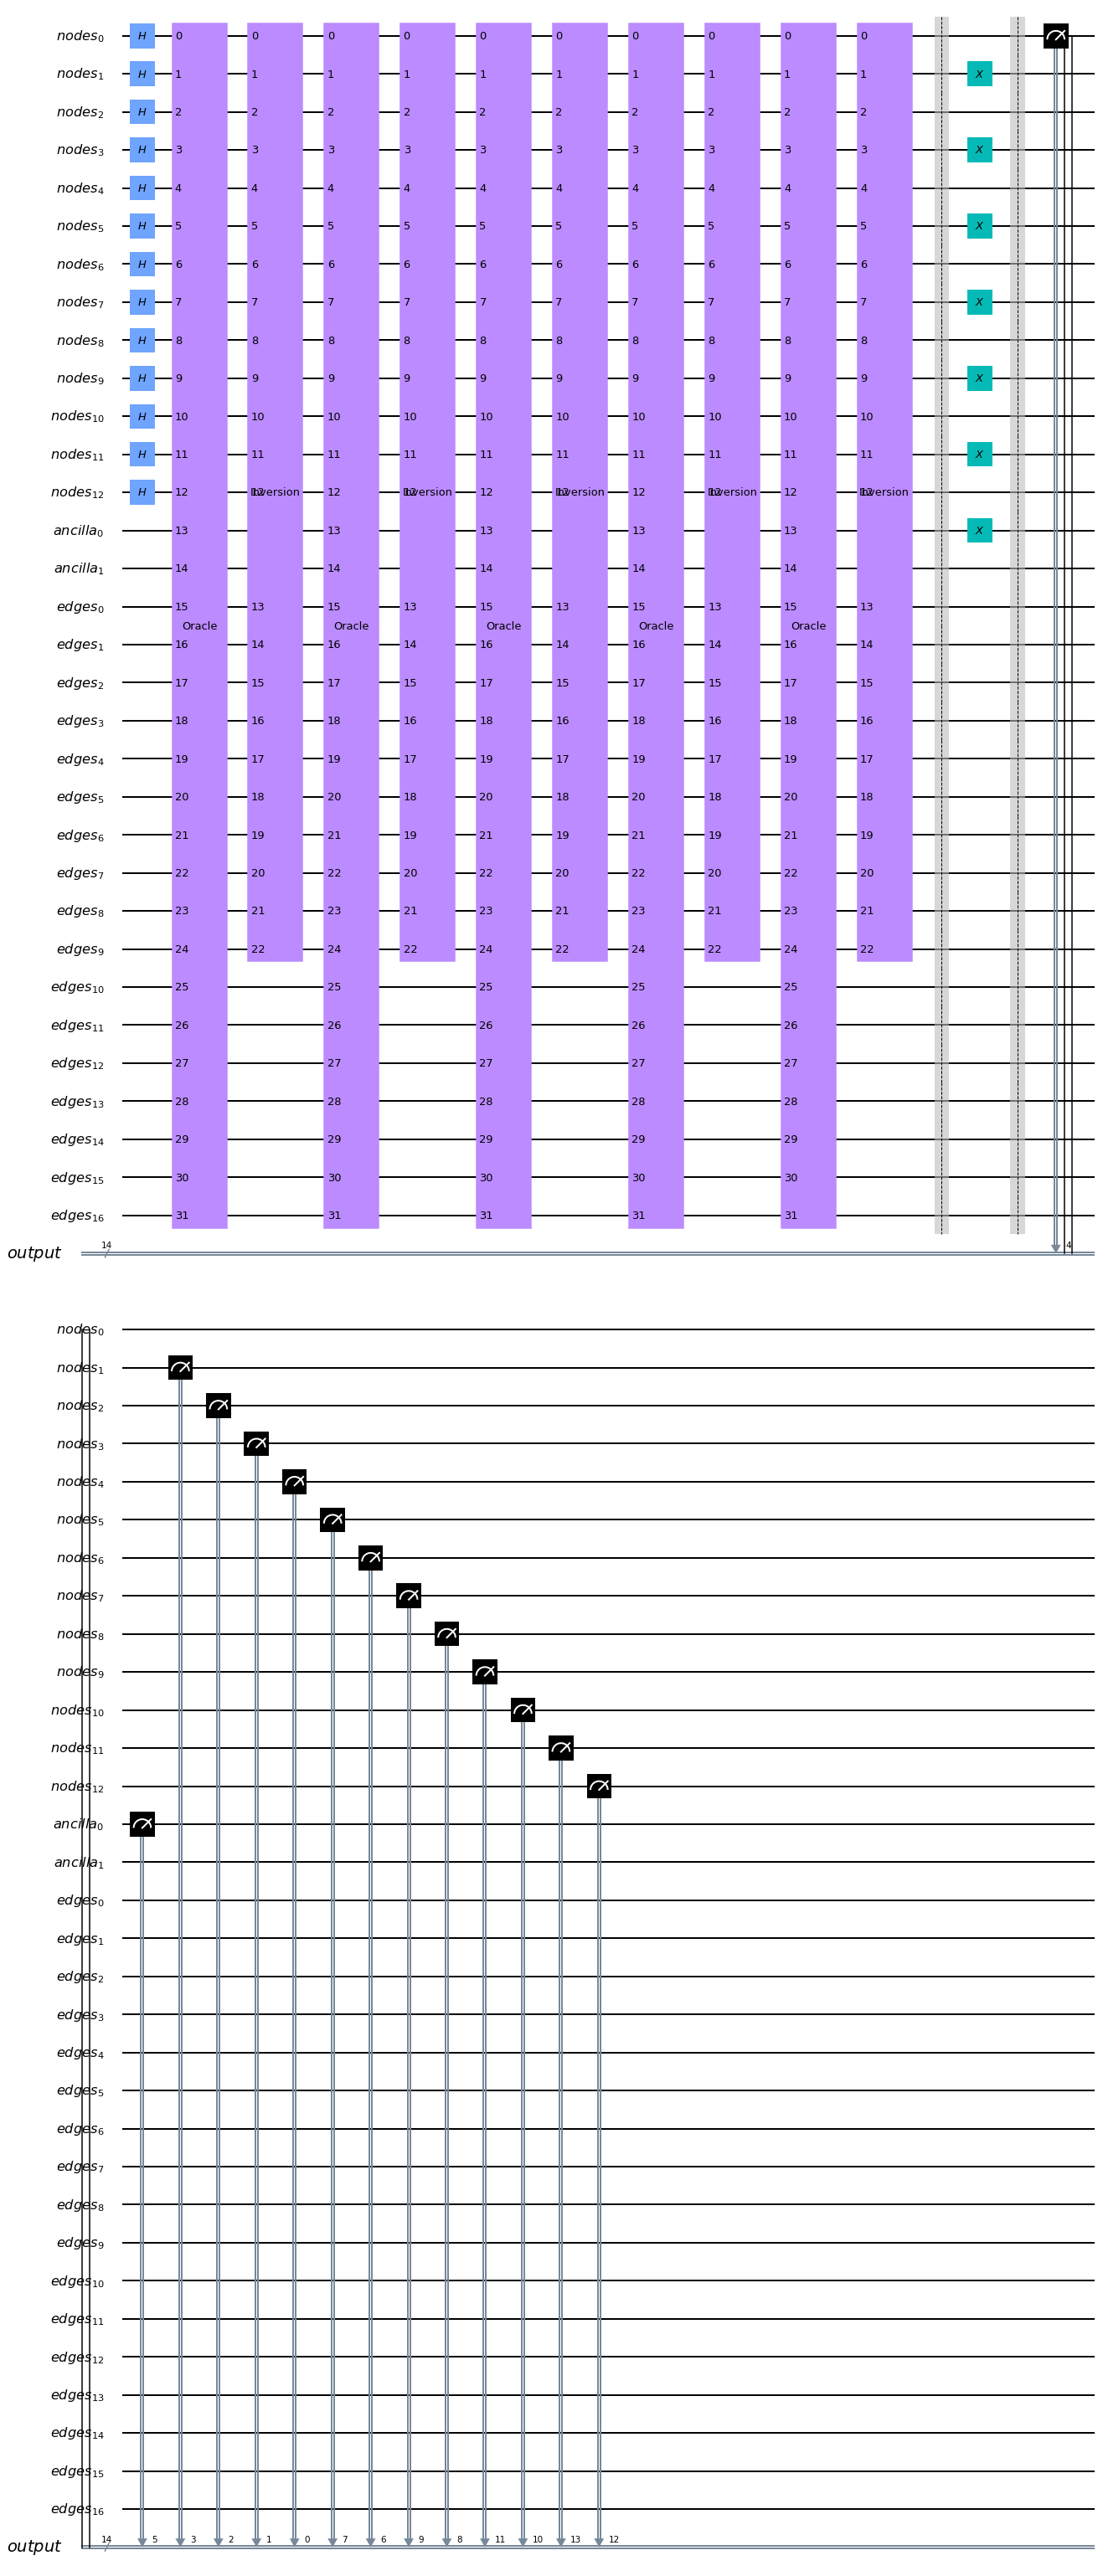

In [13]:
# encoding the graph (note that 2 is swapped with 0 for the reasons stated above)
graph = [[1,2],[0,2],[2,3],[1,3],[1,4],[0,3],[3,4],[0,5],[3,5],[0,6],[3,6],[4,6],[5,6]]

# extract the number of nodes and edges
n_nodes = max(map(max,graph))+1
n_edges = len(graph)

# we fix the first bit of the first qubit to 0 and do not allocate a qubit for it 
nodes = QuantumRegister(2*n_nodes-1,'nodes')
ancilla = QuantumRegister(2,name='ancilla')
edges = QuantumRegister(n_edges+4,'edges') # the number of edges + the 3-color exceptions


# allocating the classical registers to store the results
output = ClassicalRegister(2*n_nodes,name='output')

# creating the circuit
circuit = QuantumCircuit(nodes,ancilla,edges,output)

# put all nodes in a uniform superposition
circuit.h(nodes)

# creating the oracle and the inversion subcircuits
oracle_subcircuit = oracle(graph)
inversion_subcircuit = inversion(2*n_nodes-1)

# creating groups of qubits
oracle_qubits = [*nodes,*ancilla,*edges]
inversion_qubits = [*nodes,*edges[0:2*n_nodes-4]]

# repeat the Grover steps k times
for i in range(k):
    circuit.append(oracle_subcircuit,oracle_qubits)
    circuit.append(inversion_subcircuit,inversion_qubits)

circuit.barrier([*nodes,*ancilla,*edges])


# flipping the first bit of the colors to go back to (A:00, B:01, C:10, D:11)

circuit.x(ancilla[0]) 
for i in range(1,n_nodes):
    circuit.x(nodes[2*i-1])

circuit.barrier([*nodes,*ancilla,*edges])

# we use ancilla[0] to represent the un-encoded first bit of node 0
circuit.measure(nodes[0],output[4])
circuit.measure(ancilla[0],output[5])


circuit.measure(nodes[1],output[3])
circuit.measure(nodes[2],output[2])

circuit.measure(nodes[3],output[1])
circuit.measure(nodes[4],output[0])

circuit.measure(nodes[5],output[7])
circuit.measure(nodes[6],output[6])
                                  
circuit.measure(nodes[7],output[9])
circuit.measure(nodes[8],output[8])
                                  
circuit.measure(nodes[9],output[11])
circuit.measure(nodes[10],output[10])
                                  
circuit.measure(nodes[11],output[13])
circuit.measure(nodes[12],output[12])

# draw the circuit
circuit.draw(output='mpl')

Unrolling the circuit and calculating the cost

In [14]:
# unroll the circuit
unrolled_circuit = pm.run(circuit) 

# get the gates' counts 
gates = unrolled_circuit.count_ops()

u3_ops = gates.get('u3') # the number of u3 gates
cx_ops = gates.get('cx') # the number of cx gates

cost = u3_ops+10*cx_ops  # the total cost

print('u3=',u3_ops,', cx=',cx_ops,'->','Cost=',cost)

u3= 4305 , cx= 2580 -> Cost= 30105


In [15]:
# run the circuit
job = execute(circuit, backend=backend, shots=n_shots, seed_simulator=12345, backend_options={"fusion_enable":True})

In [16]:
# getting the results
results = job.result()
count = results.get_counts()

# Submission 

In [17]:
name='TheAxiom'
times='5'
filename=name+'_'+times+'_final_output.txt'

In [18]:
# this part is from the provided codes in the hackathon
import json

count_sorted = sorted(count.items(), key=lambda x:x[1], reverse=True)

ans_list = count_sorted[0:num_solutions]
ans_reversed = []
for i in ans_list:
    ans_temp=[i[0][::-1],i[1]]
    ans_reversed.append(ans_temp)

ans_shaped = []
for j in ans_reversed:
    ans_temp=j[0]
    nodeA = 0
    node0 = int(ans_temp[0] + ans_temp[1], 2)
    node1 = int(ans_temp[2] + ans_temp[3], 2)
    nodeB = 1
    node2 = int(ans_temp[4] + ans_temp[5], 2)
    node3 = int(ans_temp[6] + ans_temp[7], 2)
    node4 = int(ans_temp[8] + ans_temp[9], 2)
    nodeC = 2
    node5 = int(ans_temp[10] + ans_temp[11], 2)
    node6 = int(ans_temp[12] + ans_temp[13], 2)
    nodeD = 3
    nodes_color = str(nodeA) + str(node0) + str(node1) + str(nodeB) + str(node2) + str(node3) + str(node4) + str(nodeC) + str(node5) + str(node6) + str(nodeD) 
    ans_shaped.append([nodes_color,j[1]])

dct={'ans':ans_shaped,'costs':gates}
with open(filename, 'w') as f:
    json.dump(dct, f)

# Plotting

In [19]:
# import graphing packages
import networkx as nx
import matplotlib.pyplot as plt

# node labels
labels =['A','0','1','B','2','3','4','C','5','6','D']

# node labels
colors =['tomato','dodgerblue','yellow','limegreen']

# node positions
position={
    'A':(0,3), '0':(1,3), '1':(2,3), 'B':(3,3),
    '2':(0,2), '3':(1,2), '4':(2,2),
    'C':(0,1), '5':(1,1), '6':(2,1),
               'D':(1,0)
}

# node sizes
node_size = [1500]*len(labels)

# create a graph object
G = nx.Graph()

# add the nodes
G.add_nodes_from(labels)

# add the edges
G.add_edges_from([('0','1'),('0','2'),('0','3'),('0','A'),
                  ('1','3'),('1','4'),('1','B'),
                  ('2','3'),('2','5'),('2','6'),('2','A'),('2','C'),
                  ('3','4'),('3','5'),('3','6'),('3','A'),
                  ('4','6'),('4','B'),
                  ('5','6'),('5','D'),
                  ('6','D'),
                  ('C','D')])

In [20]:
from pathlib import Path

# read the colors from the file
filename = name+'_'+times+'_final_output.txt'
p = Path(filename)

with open(p, 'r') as f:
    answers=json.load(f)

color_maps = [[]]*len(answers['ans'])

for i in range(len(answers['ans'])):
    answer = answers['ans'][i][0]
    color_maps[i] = [colors[int(answer[0], 10)]]
    color_maps[i].append(colors[int(answer[1], 10)])
    color_maps[i].append(colors[int(answer[2], 10)])
    color_maps[i].append(colors[int(answer[3], 10)])
    color_maps[i].append(colors[int(answer[4], 10)])
    color_maps[i].append(colors[int(answer[5], 10)])
    color_maps[i].append(colors[int(answer[6], 10)])
    color_maps[i].append(colors[int(answer[7], 10)])
    color_maps[i].append(colors[int(answer[8], 10)])
    color_maps[i].append(colors[int(answer[9], 10)])
    color_maps[i].append(colors[int(answer[10], 10)])

/miniconda3/envs/qiskit/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


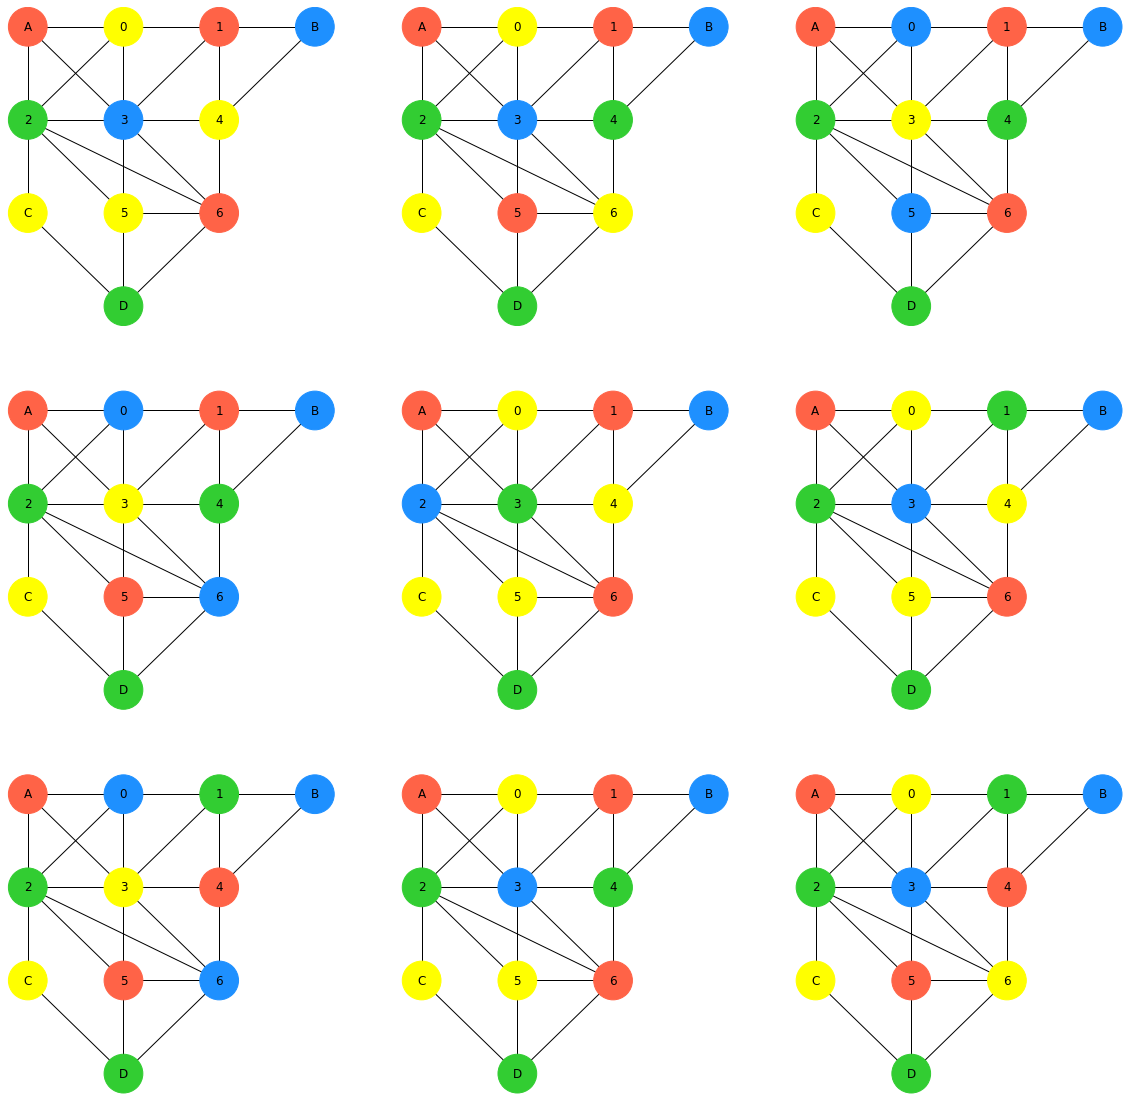

In [21]:
# create a 3 by 3 grid for the 9 answers
fig, ax = plt.subplots(3, 3, figsize=(20,20))

# for each answer
for i in range(len(answers['ans'])):
    # get the corresponding index 
    ix = np.unravel_index(i, ax.shape)
    
    # set as current plot
    plt.sca(ax[ix])
    
    # turn off axis-labels
    ax[ix].set_axis_off()

    # draw the 
    nx.draw(G,position,node_color = color_maps[i],node_size = node_size, with_labels=True)